## Problem 1

In [6]:
import h5py
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.signal
import json
from scipy.ndimage import gaussian_filter

In [2]:
path_to_data = 'LOSC_Event_tutorial/'

In [3]:
import simple_read_ligo as read
f = open(path_to_data+ 'BBH_events_v3.json')
events = json.load(f)

In [9]:
class mf(object):
    def __init__(self,event):
        
        '''load the templates and data for each detector for given event and read out data'''
        L_path =  path_to_data +  events[event]['fn_L1']
        H_path =  path_to_data + events[event]['fn_H1']
        template_path = path_to_data + events[event]['fn_template']
        
        self.strain_L,self.dt_L,self.utc_L=read.read_file(L_path)
        self.strain_H,self.dt_H,self.utc_H=read.read_file(H_path)
        self.TH,self.TL=read.read_template(template_path)
        
        self.fft_strain_L = np.fft.rfft(self.strain_L)
        self.fft_strain_H = np.fft.rfft(self.strain_H)
        
        self.fft_TH = np.fft.rfft(self.TH)
        self.fft_TL = np.fft.rfft(self.TL)
        
        
    def window(self, data, alpha=0.5):
        '''window any given strain or template using Tukey window (cosine with flat top)'''
        
        n=len(data)
        win = scipy.signal.windows.tukey(n,alpha)
        
        self.data_win = data*win 
        self.fft_data_win = np.fft.rfft(data*win)
        
        return self.fft_data_win
        
        
    def whiten_smooth(self,data,strain):
        '''Given data should go through window function'''
        
        self.NM = np.abs(strain)**2
        self.N_smooth = gaussian_filter(self.NM, sigma=50)
        
        white_fft=data/np.sqrt(self.N_smooth)
        white =np.fft.irfft(white_fft)
        
        return white, white_fft, self.N_smooth
    
    
    def matched_filter(self,strain,template):
        '''Strain and template are both windowed, smoothed and whitened'''
        
        xcorr = np.fft.irfft((strain)*np.conj(template))
        xcorr_fft = strain*np.conj(template)
        

        return xcorr,xcorr_fft
    
    
    def find_weight(self,mf_fft):
        '''Matched filter is in fft space'''
        
        #find the time span for time in spatial space 
        t = np.linspace(0,32,len(mf_fft)*2)
        

        #convert to fourier space to get frequencies 
        freq = np.fft.rfftfreq(len(t),1/4096)

        
        #plt.plot(freq[1:], mf_fft )

        #find the half of the total area
        area = np.sum(np.abs(mf_fft)*(freq[1]-freq[0]))
        target = area/2

        #loop to find frequency
        for i in range(len(freq)): 
            area = np.sum(np.abs(mf_fft[:i])*(freq[1]-freq[0]))
            #print(area)
            if np.abs(area - target ) < 5: 
                half_freq = freq[i]
                #print('Found the frequency')
                break
        return half_freq
        

Below is the noise templates for each event and location. These are all windowed with a Tukey window and smoothed using a gaussian. The noise model is then used to whiten the strain and the template.

## Noise Models - Livingstong

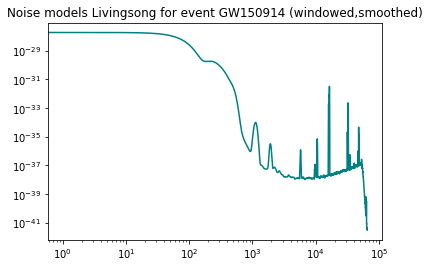

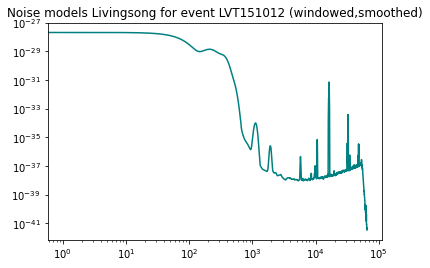

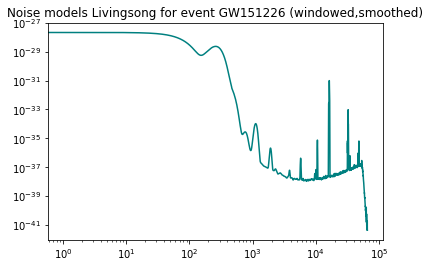

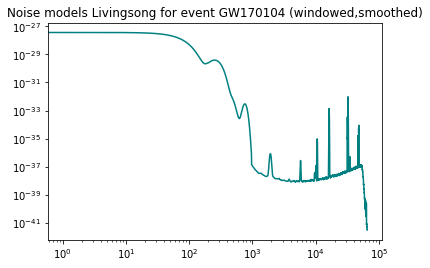

In [10]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    get_mf = mf(i)
    
    ps = get_mf.whiten_smooth(get_mf.window(get_mf.TL),get_mf.window(get_mf.strain_L))[2]
    
    plt.title('Noise models Livingsong for event {} (windowed,smoothed)'.format(i))
    plt.loglog(ps,color= 'teal' )
    plt.show()


## Noise Models - Hanford

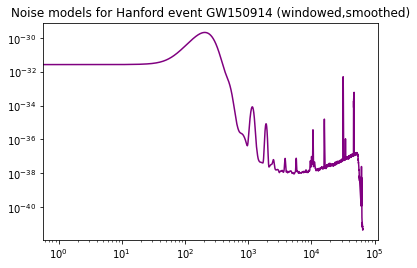

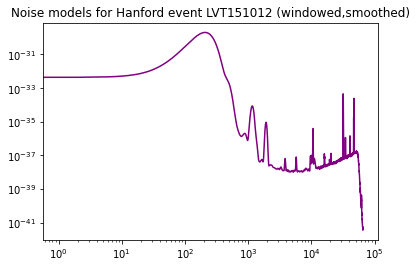

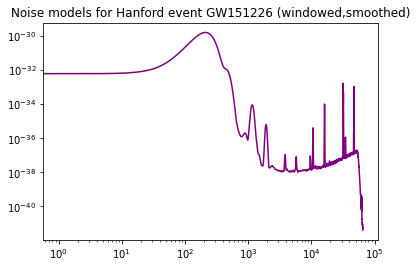

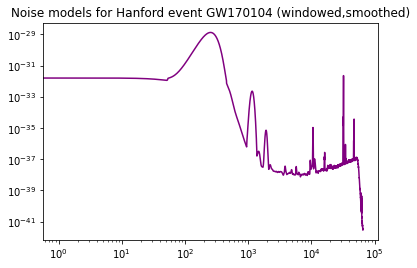

In [11]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    get_mf = mf(i)
    
    ps = get_mf.whiten_smooth(get_mf.window(get_mf.TH),get_mf.window(get_mf.strain_H))[2]
    
    plt.title('Noise models for Hanford event {} (windowed,smoothed)'.format(i))
    plt.loglog(ps,color= 'purple' )
    plt.show()

Next is the matched filters which are the correlation between the windowed, smoothed, and whitened strains and templates, they show the peak of the least squares fit between the strain and the template as one is moved across the other. This is the location of the gravitational wave above the noise.

## Matched filters Livingston

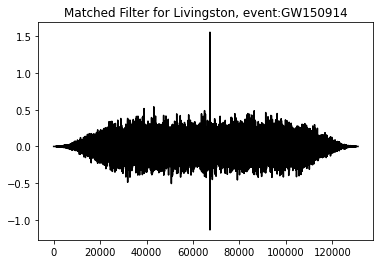

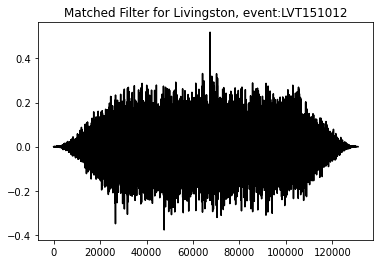

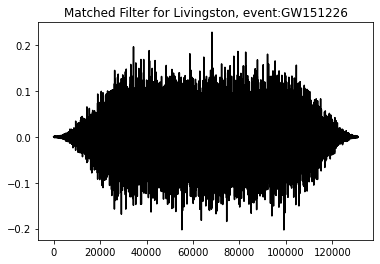

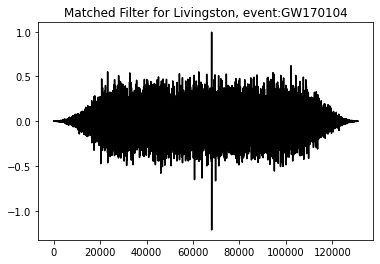

In [12]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TL),get_mf.window(get_mf.strain_L))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_L),get_mf.window(get_mf.strain_L))[1]
    
    xcorr = get_mf.matched_filter(white_s, white_T)[0]
    
    plt.plot(np.fft.fftshift(xcorr),'k')
    plt.title('Matched Filter for Livingston, event:{}'.format(i))
    plt.show()
    
    

## Matched filters Hanford

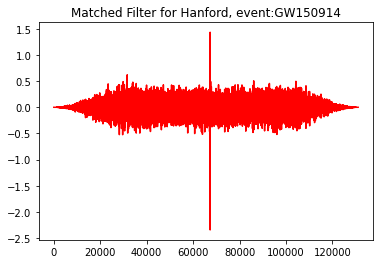

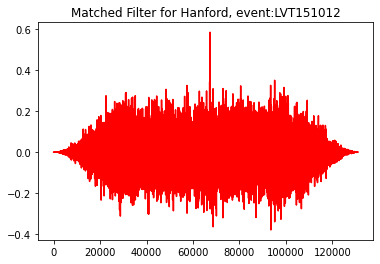

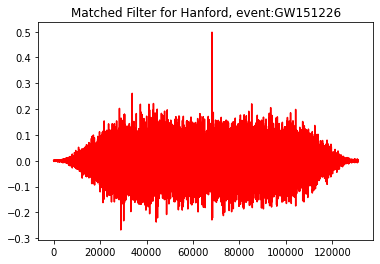

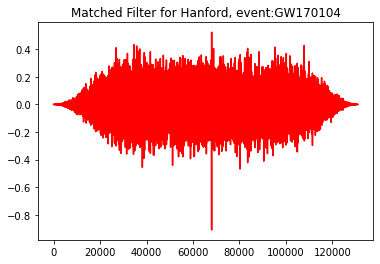

In [13]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TH),get_mf.window(get_mf.strain_H))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_H),get_mf.window(get_mf.strain_H))[1]
    
    xcorr = get_mf.matched_filter(white_s, white_T)[0]
    
    plt.plot(np.fft.fftshift(xcorr),'r')
    plt.title('Matched Filter for Hanford, event:{}'.format(i))
    plt.show()
    

The scatter signal to noise is computed by taking the standard deviation of a chunck of the noise in the matched filter where there is no signal and then dividing that from the peak value where the gravitational wave is. The analytical signal to noise is computed by taking the matched filter of the whitened template with itself. This represents what would we expect to get for the signal to noise. As seen below the values are relatively consistent but are not exact. This is because the scatter signal comes from the actual data strain which has a lot more correlated noise and although we attempted to smooth and whiten it, this could be improved upon.

## SNR - Livington

In [14]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TL),get_mf.window(get_mf.strain_L))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_L),get_mf.window(get_mf.strain_L))[1]

    
    #get the analytical snr
    L = np.abs(get_mf.matched_filter(white_T, white_T)[0])
    L_snr_an =  np.max(L)/ np.std(L[:2000])


    #get the calculated snr 
    xcorr = np.abs(get_mf.matched_filter(white_s, white_T)[0])
    L_snr = xcorr.max()/ np.std(np.abs(xcorr[10000:30000]))
    
    print('Noise for Livingston event {} is {}'.format(i,np.std(np.abs(xcorr[10000:30000]))))
    print('Sactter SNR for Livingston event {} is {}'.format(i,L_snr))
    print('Analytical SNR for Livingston event {} is {}'.format(i,L_snr_an))
    print('')



Noise for Livingston event GW150914 is 0.07926214451874226
Sactter SNR for Livingston event GW150914 is 19.61604678042056
Analytical SNR for Livingston event GW150914 is 18.917177278819313

Noise for Livingston event LVT151012 is 0.052945749897747515
Sactter SNR for Livingston event LVT151012 is 9.794986767590975
Analytical SNR for Livingston event LVT151012 is 17.49330618948786

Noise for Livingston event GW151226 is 0.029555330486182918
Sactter SNR for Livingston event GW151226 is 7.726545695983427
Analytical SNR for Livingston event GW151226 is 19.512725258538975

Noise for Livingston event GW170104 is 0.09528037066736741
Sactter SNR for Livingston event GW170104 is 12.740213560020514
Analytical SNR for Livingston event GW170104 is 16.005313026151992



## SNR - Hanford

In [15]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TH),get_mf.window(get_mf.strain_H))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_H),get_mf.window(get_mf.strain_H))[1]

    
    #get the analytical snr
    H = np.abs(get_mf.matched_filter(white_T, white_T)[0])
    H_snr_an =  np.max(H)/ np.std(H[:2000])


    #get the calculated snr 
    xcorr = np.abs(get_mf.matched_filter(white_s, white_T)[0])
    H_snr = xcorr.max()/ np.std((xcorr[10000:30000]))
    
    print('Noise for Hanford event {} is {}'.format(i,np.std(np.abs(xcorr[10000:30000]))))
    print('Sactter SNR for Hanford event {} is {}'.format(i,H_snr))
    print('Analytical SNR for Hanford event {} is {}'.format(i,H_snr_an))
    print('')

Noise for Hanford event GW150914 is 0.08119588295170349
Sactter SNR for Hanford event GW150914 is 28.875606814230892
Analytical SNR for Hanford event GW150914 is 18.492437307873118

Noise for Hanford event LVT151012 is 0.05292830892475887
Sactter SNR for Hanford event LVT151012 is 11.053841038446553
Analytical SNR for Hanford event LVT151012 is 17.129639561488727

Noise for Hanford event GW151226 is 0.03592243934584607
Sactter SNR for Hanford event GW151226 is 13.857255430033101
Analytical SNR for Hanford event GW151226 is 15.99382331899513

Noise for Hanford event GW170104 is 0.06817086881341825
Sactter SNR for Hanford event GW170104 is 13.345869766609509
Analytical SNR for Hanford event GW170104 is 18.28737079579846



In [56]:
1126259462.4395 - 1126259462.4324 

0.007100105285644531

## SNR - Combined

For the combined SNR we can add the SNRs from Livington and Hanford in quadrature. 

In [21]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TL),get_mf.window(get_mf.strain_L))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_L),get_mf.window(get_mf.strain_L))[1]

    
    #get the analytical snr
    L = np.abs(get_mf.matched_filter(white_T, white_T)[0])
    L_snr_an =  np.max(L)/ np.std(L[:2000])


    #get the calculated snr 
    xcorr = np.abs(get_mf.matched_filter(white_s, white_T)[0])
    L_snr = xcorr.max()/ np.std(np.abs(xcorr[10000:30000]))
    
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TH),get_mf.window(get_mf.strain_H))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_H),get_mf.window(get_mf.strain_H))[1]

    
    #get the analytical snr
    H = np.abs(get_mf.matched_filter(white_T, white_T)[0])
    H_snr_an =  np.max(H)/ np.std(H[:2000])


    #get the calculated snr 
    xcorr = np.abs(get_mf.matched_filter(white_s, white_T)[0])
    H_snr = xcorr.max()/ np.std((xcorr[10000:30000]))
    

    combined_snr_an = np.sqrt(H_snr_an**2 + L_snr_an**2)
    combined_snr = np.sqrt(H_snr**2 + L_snr**2)
    
    print('Combined scatter SNR for event {} is {}'.format(i,combined_snr))
    print('Combined analytical SNR for event {} is {}'.format(i,combined_snr_an))
    print('')


Combined scatter SNR for event GW150914 is 34.90830789628316
Combined analytical SNR for event GW150914 is 26.454297075974168

Combined scatter SNR for event LVT151012 is 14.769196575322825
Combined analytical SNR for event LVT151012 is 24.483470198190737

Combined scatter SNR for event GW151226 is 15.865781936144902
Combined analytical SNR for event GW151226 is 25.22991936916282

Combined scatter SNR for event GW170104 is 18.450617371303117
Combined analytical SNR for event GW170104 is 24.302221620422543



In order to find the freqeuncy where hald of the weight is above and below we can set up the following integreal (done in the find_weight method of the class): 

$\int_0^{f_i} \tilde{MF} dt  = \frac{1}{2}\int_0^{f_{max}} \tilde{MF} dt$

Where $\tilde{MF}$ is the fourier transform of the matched filter. We take the fourier transform in order to see it in frequency space. We are looking for the frequency $f_i$ which corresponds with half the total area in fourier space. This also requires calculating the time span of the events and converting them to fourier space as seen in the find_weight method.



## Frequency of even weight - Livingston 

In [18]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TL),get_mf.window(get_mf.strain_L))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_L),get_mf.window(get_mf.strain_L))[1]
    
    xcorr_fft = get_mf.matched_filter(white_s, white_T)[1]
    freq = get_mf.find_weight(xcorr_fft)
    
    print('Frequency for half weight for Livingston, event {} is {} Hz'.format(i,freq))

    

Frequency for half weight for Livingston, event GW150914 is 140.9978485435708 Hz
Frequency for half weight for Livingston, event LVT151012 is 135.3104353266094 Hz
Frequency for half weight for Livingston, event GW151226 is 186.96589712681387 Hz
Frequency for half weight for Livingston, event GW170104 is 119.2169308939988 Hz


## Frequency of even weight - Harford

In [19]:
all_e = ['GW150914','LVT151012','GW151226','GW170104']

for i in all_e: 
    
    get_mf = mf(i)
    
    white_T = get_mf.whiten_smooth(get_mf.window(get_mf.TH),get_mf.window(get_mf.strain_H))[1]
    white_s = get_mf.whiten_smooth(get_mf.window(get_mf.strain_H),get_mf.window(get_mf.strain_H))[1]
    
    xcorr_fft = get_mf.matched_filter(white_s, white_T)[1]
    freq = get_mf.find_weight(xcorr_fft)
    
    print('Frequency for half weight for Hanford, event {} is {} Hz'.format(i,freq))

Frequency for half weight for Hanford, event GW150914 is 141.65408853014327 Hz
Frequency for half weight for Hanford, event LVT151012 is 137.2791552863268 Hz
Frequency for half weight for Hanford, event GW151226 is 158.96632436638845 Hz
Frequency for half weight for Hanford, event GW170104 is 145.46653035689764 Hz


See attatchment for part f 

## Problem 2

<ipython-input-87-26af75148db1>:10: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(-r**2/(2*sig**2))*2*np.pi*r
<ipython-input-87-26af75148db1>:30: RuntimeWarning: invalid value encountered in true_divide
  f = num / den


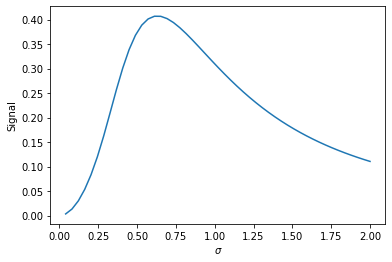

In [87]:
from scipy.integrate import quad
R = 1
sig = np.linspace(0,2)

# area of dish 
A = np.pi*R**2

# set up integral 
def integrand(r, sig):
    return np.exp(-r**2/(2*sig**2))*2*np.pi*r

# Integrate to get A_eff 

A_eff =[]
for i in sig:
    A_eff.append(quad(integrand, 0, R, args=i)[0])
A_eff = np.array(A_eff)

# Integrate to get f  
num = []
for i in sig:
    num.append(quad(integrand, 0, R, args=i)[0])
num = np.array(num)

den =[]
for i in sig:
    den.append(quad(integrand, 0, np.inf, args=i)[0])
den = np.array(den)

f = num / den


plt.plot(sig,(A_eff/A)*f) 
plt.ylabel('Signal')
plt.xlabel('$\sigma$')
plt.show()


The maximum signal at the feed will occur when $\frac{A_{eff}}{A}f$ peaks because that means that the fraction of the beam that is staying on the dish is maximized, but also $A_{eff}$ is large enough so that the signal is not concentrated to a small part of the dish. 

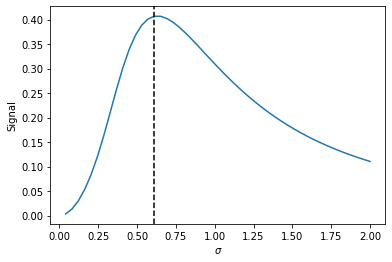

The max signal occurs at a sigma of: 0.612
A_eff/A at the peak equals: 0.552
Fraction of the beam that ends up off the primary: 26.35%


In [94]:
s = (A_eff/A)*f
sig_max = sig[s == np.nanmax(s)][0]

plt.plot(sig,(A_eff/A)*f) 
plt.axvline(x = sig_max,color='k',linestyle ='--')
plt.ylabel('Signal')
plt.xlabel('$\sigma$')
plt.show()

print(f'The max signal occurs at a sigma of: {sig_max:.3f}')

# calculate A_eff/A at the peak
A_eff_A = quad(integrand, 0, R, args=sig_max)[0]/A

print(f'A_eff/A at the peak equals: {A_eff_A:.3f}')

# calculate the fraction of the beam the ends up off the primary
num=quad(integrand, 0, R, args=sig_max)[0]
den=quad(integrand, 0, np.inf, args=sig_max)[0]

f_off = (1 - (num / den))*100

print(f'Fraction of the beam that ends up off the primary: {f_off:.2f}%')